In [64]:
import torch
import numpy as np
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt

In [65]:
def read(path):
    file = open(path, encoding='utf8')
    lines = [line for line in file.readlines()]
    file.close()
    return lines

In [66]:
train_negative = 'train_negative_tokenized.txt'
train_neural = 'train_neutral_tokenized.txt'
train_positive = 'train_neutral_tokenized.txt'

In [67]:
negative = read(train_negative)
neural = read(train_neural)
positive = read(train_negative)

In [68]:
train_set = negative + neural + positive
train_set = negative

# bỏ những dòng trống
train_set = [i for i in train_set if i != '\n']
size = len(train_set)

# đưa tất cả về chữ thường
for i in range(size):
    train_set[i] = train_set[i].lower()

# bỏ các ký tự unicode
for i in range(size):
    train_set[i] = train_set[i].replace('\ufeff', '').replace('\xa0', '').replace('\u200e', '').replace('\u200b', '')

# bỏ các chuỗi mặt cười
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])

# bỏ các chuỗi '...'
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])


In [69]:
train_set_cleaned = train_set
vocab = Counter()

for i, sentence in enumerate(train_set):
    train_set[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        vocab.update([word]) # cập nhật số lần xuất hiện của word
        train_set[i].append(word)
vocab_ = vocab

In [70]:
vocab = sorted(vocab, key=vocab.get, reverse=True) # sắp xếp theo thứ tự tần suất xuất hiện giảm dần

In [71]:
w2i = {w:i+1 for i,w in enumerate(vocab)} # w2i[word] ->  mức độ xuất hiện word trong corpus
# (1 là xuất hiện nhiều nhất, số 0 để padding)

In [72]:
vocab_sorted = vocab
for i, sentence in enumerate(train_set):
    train_set[i] = [w2i[word] if word in w2i else 0 for word in sentence] # thay từ bằng w2i của từ, nếu không trong corpus -> 0

In [73]:
count = np.zeros(len(train_set))
for s in train_set:
    count[len(s)] += 1

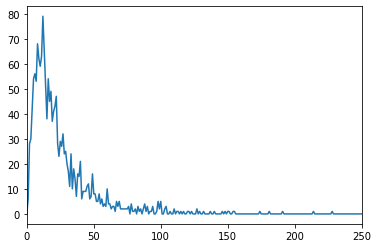

In [74]:
plt.plot(count)
plt.xlim((0,250))
plt.show() # phân bố độ dài các câu

In [75]:
normalized_len = 15 # đa số câu đều < 150, chuẩn hóa độ dài câu về 150

In [76]:
def normalize_length(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype = int)
    
    for i, review in enumerate(sentences):
        review_len = len(review)
        
        if review_len <= seq_length: # ngắn hơn seq_length -> chèn thêm 0 vào đầu
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length: # dài hơn -> chỉ lấy <seq_length> số đầu tiên
            new = review[0:seq_length]
        
        features[i] = np.array(new)
    return features

In [77]:
train_set = normalize_length(train_set, normalized_len)
train_set

array([[  12,   39,   11, ...,   65,  427, 1684],
       [1087,  342,  379, ..., 1088, 1089,    2],
       [2415,   49,   26, ..., 1686, 2417,  798],
       ...,
       [   0,    0,    0, ...,   70,  191,  168],
       [   0,    0,    0, ..., 5148,  102,    1],
       [   0,    0,    0, ...,  224, 5149,   20]])